<a href="https://colab.research.google.com/github/SherinBojappa/prompting/blob/main/GPT_3_prompting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 44 kB 2.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163 kB 28.7 MB/s 
  Created wheel for openai: filename=openai-0.25.0-py3-none-any.whl size=55880 sha256=5a43c5aca01c50a86dd8fc1830be4eb15b2d4c606622442eb5506c12121ab551
  Stored in directory: /root/.cache/pip/wheels/19/de/db/e82770b480ec30fd4a6d67108744b9c52be167c04fcf4af7b5
Successfully built openai


In [ ]:
import openai

In [ ]:
# open ai api key
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
# get openai api key from dashboard
f = open('open_ai_key.txt', 'r')
key = f.readlines()
f.close()
openai.api_key = key[0].strip('\n')

In [ ]:
# get rte dataset from huggingface
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 14.6 MB/s 
     |████████████████████████████████| 212 kB 70.9 MB/s 
     |████████████████████████████████| 115 kB 56.8 MB/s 
     |████████████████████████████████| 182 kB 60.0 MB/s 
     |████████████████████████████████| 127 kB 66.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import datasets as datasets

In [ ]:
# RTE dataset from Super GLUE - https://paperswithcode.com/sota/natural-language-inference-on-rte
# 0 - enatilment
# 1 - not entailment
dataset = 'rte'

In [ ]:
if dataset == 'rte':
  train_set = datasets.load_dataset('super_glue',dataset, split='train')
  dev_set = datasets.load_dataset('super_glue', dataset, split='validation')

Generating train split:   0%|          | 0/2490 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/277 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Dataset super_glue downloaded and prepared to /root/.cache/huggingface/datasets/super_glue/rte/1.0.3/bb9675f958ebfee0d5d6dc5476fafe38c79123727a7258d515c450873dbdbbed. Subsequent calls will reuse this data.


In [ ]:
train_set.shape

(2490, 4)

In [ ]:
type(dev_set)

datasets.arrow_dataset.Dataset

In [ ]:
dev_set.shape

(277, 4)

In [ ]:
train_set[5]

{'premise': 'Britain said, Friday, that it has barred cleric, Omar Bakri, from returning to the country from Lebanon, where he was released by police after being detained for 24 hours.',
 'hypothesis': 'Bakri was briefly detained, but was released.',
 'idx': 5,
 'label': 0}

In [ ]:
# create a new toy dataset with very few examples from train dataset
new_toy_set = {}

In [ ]:
for i in range(0,5):
  new_toy_set[i] = dev_set[i]

In [ ]:
# actual results from rte dataset
true_label = [new_toy_set[sample]['label'] for sample in new_toy_set]
print(true_label)

NameError: ignored

In [ ]:
import pandas as pd

In [ ]:
# import templates from 
# https://github.com/awebson/prompt_semantics/blob/main/data/binary_NLI_prompts.csv
templates_df = pd.read_csv('binary_NLI_prompts.csv')

In [ ]:
# target categories
target_categories = {}

# yes no category
target_categories["yes_no"] = 'yes;no'

# yes no like category
target_categories["true_false"] = 'true;false'
target_categories["pos_neg"] = 'positive;negative'

# reversed
target_categories["no_yes"] = 'no;yes'
target_categories["false_true"] = 'false;true'

# arbitrary
target_categories["arbit"] = 'cat;dog'

# relevant
target_categories["ent_not_ent"] = 'enatailment;non-entailment'
#target_categories = [yes_no, true_false, pos_neg, no_yes, false_true, arbit]

In [ ]:
#create a dataframe with premise, hypothesis, and labels as this will be the same everywhere.
# label = 0 entailment and label=1 non entailment
#data_df = pd.DataFrame.from_dict(new_toy_set, orient='index')
#https://towardsdatascience.com/use-the-datasets-library-of-hugging-face-in-your-next-nlp-project-94e300cca850
data_df = pd.DataFrame(dev_set)

In [ ]:
def create_prompt(premise, hypothesis, template):
  template = template.replace('{premise}', premise)
  template = template.replace('{hypothesis}', hypothesis)
  return template


In [ ]:
# dataset - name of the dataset
# templates_df - df containing handwritten templates
# template_names - names of templates to pick
# given a downstream dataset and the handwritten templates and a certain template name and label category
def create_prompt_df(data_df, templates_df, template_name, label_category):
  columns = ['template_name', 'template', 'prompt_category', 'prompt', 'prompt_len', 'true_label', 'label_category']
  prompt_df = pd.DataFrame(columns = columns)
  
  # extract the template for the prompt based on the template name
  # extract the category of prompt: instructive, irrelevant or misleading
  template = templates_df.loc[templates_df['template_name'] == template_name]['template'].values[0]
  prompt_category = templates_df.loc[templates_df['template_name'] == template_name]['template_category'].values[0]

  # create the prompt by replacing premise and hypothesis with actual premise
  # and hypothesis from the dataset.
  prompt_df['prompt'] = data_df.apply(lambda x: create_prompt(x['premise'], x['hypothesis'], template), axis=1)
  prompt_df['prompt_len'] = prompt_df['prompt'].apply(lambda x: len(x.split(" ")))

  prompt_df['true_label'] = data_df['label']
  prompt_df['template_name'] = template_name
  prompt_df['template'] = template
  prompt_df['prompt_category'] = prompt_category
  prompt_df['label_category'] = label_category

  
  #TODO add the demonstrations as well to have few shot; for now just have
  # the zero shot prompts.
  return prompt_df



CHANGE THE TEMPLATE NAME AND CATEGORY SUITABLY

In [ ]:
template_name = 'MNLI_YN'
tgt_cat = target_categories['yes_no']
prompt_df_yes_no_instructive = create_prompt_df(data_df, templates_df, template_name, tgt_cat)
df = prompt_df_yes_no_instructive
template = templates_df.loc[templates_df['template_name'] == template_name]['template'].values[0]

In [ ]:
df.head()

,template_name,template,prompt_category,prompt,prompt_len,true_label,label_category
0,MNLI_YN,{premise} Using only the above description and...,instructive,"Dana Reeve, the widow of the actor Christopher...",28,1,yes;no
1,MNLI_YN,{premise} Using only the above description and...,instructive,"Yet, we now are discovering that antibiotics a...",38,0,yes;no
2,MNLI_YN,{premise} Using only the above description and...,instructive,Cairo is now home to some 15 million people - ...,137,1,yes;no
3,MNLI_YN,{premise} Using only the above description and...,instructive,"The Amish community in Pennsylvania, which num...",108,1,yes;no
4,MNLI_YN,{premise} Using only the above description and...,instructive,Security forces were on high alert after an el...,35,0,yes;no


In [ ]:
template_name = 'justified_in_saying'
tgt_cat = target_categories['true_false']
prompt_df_true_false_instructive = create_prompt_df(data_df, templates_df, template_name, tgt_cat)
df = prompt_df_true_false_instructive
template = templates_df.loc[templates_df['template_name'] == template_name]['template'].values[0]

In [ ]:
template_name = 'zoning'
tgt_cat = target_categories['true_false']
prompt_df_true_false_instructive = create_prompt_df(data_df, templates_df, template_name, tgt_cat)
df = prompt_df_true_false_instructive
template = templates_df.loc[templates_df['template_name'] == template_name]['template'].values[0]

In [ ]:
template_name = 'zoning'
tgt_cat = target_categories['yes_no']
prompt_df_true_false_instructive = create_prompt_df(data_df, templates_df, template_name, tgt_cat)
df = prompt_df_true_false_instructive
template = templates_df.loc[templates_df['template_name'] == template_name]['template'].values[0]

In [ ]:
template_name = 'justified_in_saying'
tgt_cat = target_categories['yes_no']
prompt_df_true_false_instructive = create_prompt_df(data_df, templates_df, template_name, tgt_cat)
df = prompt_df_true_false_instructive
template = templates_df.loc[templates_df['template_name'] == template_name]['template'].values[0]

In [ ]:
# random sampling of the training dataset examples to create demonstrations.
# randomly sample 4 examples from the training set - pick one number and the other 3 are the consecutive

import random
num_shots = 4
max_ind = len(train_set)-4
# randint gives same number when you fix the seed
random.seed(1)
start_ind = random.randint(0, max_ind)
sample_indices = range(start_ind, start_ind + num_shots)


In [ ]:
# create examples such that you can easily remove them and have a k-1 shot if they exceed the context window length
demonstration_shots = {}
for index in range(num_shots):
  ex = train_set.select(sample_indices)[index]
  prompt = create_prompt(ex['premise'], ex['hypothesis'], template)
  # append the label to the example
  target = ex['label']
  label_category = tgt_cat
  labels = label_category.rstrip().split(';')
  true_label = labels[0]    # enatailment
  false_label = labels[1]   # non enatailment
  if target == 0:
    prompt = prompt + ' ' + true_label + '\n'
  elif target == 1:
    prompt = prompt + ' ' + false_label + '\n'

  demonstration_shots[index] = prompt


In [ ]:
demonstration_shots

{0: 'In any case, the fact that this week Michael Melvill, a 63-year-old civilian pilot, guided a tiny rocket-ship more than 100 kilometres above the Earth and then glided it safely back to Earth, is a cause for celebration. Using only the above description and what you know about the world, "Michael Melvill guided more than 100 rocket-ships above the Earth." is definitely correct. Yes or no? no\n',
 1: 'Christopher Reeve, an actor and director who became an inspiration worldwide after being paralyzed in a horse riding accident, died Sunday of heart failure. Using only the above description and what you know about the world, "Christopher Reeve had an accident." is definitely correct. Yes or no? yes\n',
 2: 'Further evidence emerged on Wednesday of the severe downturn in the aviation sector as Emirates pulled its giant Airbus A380s off the Dubai to New York route. The airline blamed the weakening global economy for the decision, an embarrassing U-turn only eight months after its A380 se

In [ ]:
# apply demonstrations to prompts but make sure that the number of tokens for 
# each demonstration doesnt exceed 1500 based on OpenAIs recommendation
# # https://beta.openai.com/docs/introduction/key-concepts 
# One limitation to keep in mind is that your text prompt and generated 
# completion combined must be no more than the model's maximum context length 
# (for most models this is 2048 tokens, or about 1500 words).
# if the number of words increases 1500 just reduce the number of shots.
def apply_demo_to_prompts(demos, num_shots, prompt, prompt_len):
  # try num_shots first
  dem = ''
  for num in range(num_shots):
    dem = dem + demos[num]
  
  shots = num_shots
  demo_len = len(dem.split(" "))
  while(demo_len + prompt_len > 1500):
    shots = shots - 1
    dem = ''
    # empty demonstrations will be returned if the prompt length is too big.
    if shots == 0:
      break
    for num in range(shots):
      dem = dem + demos[num]
    
    demo_len = len(dem.split(" "))

  dem = dem + prompt
  
  return dem


In [ ]:
# create a column with demonstrations and prompt
df['demo_and_prompt'] = df.apply(lambda x: apply_demo_to_prompts(demonstration_shots,
                                                                                  num_shots,
                                                                                   x['prompt'], x['prompt_len']), axis=1)
df['demo_and_prompt_len'] =  df.apply(lambda x: len(x['demo_and_prompt']), axis=1)                                         

In [ ]:
def query_gpt_3(prompt):
  # set temperature = 0 because classification problem and you want similar results all the time
  response = openai.Completion.create(engine='text-davinci-001', prompt=prompt, max_tokens = 5, temperature=0)
  return response

In [ ]:
import time
import pickle


In [ ]:
gpt_3_results = []
count = 1
for index, row in df.iterrows():
  print(count)
  resp = query_gpt_3(row['demo_and_prompt'])
  #print(row['demo_and_prompt'])
  gpt_3_results.append(resp)
  with open('gpt-3.pkl', 'wb') as f:
    pickle.dump(gpt_3_results, f)
  count+=1
  if count == 30:
    time.sleep(60)
    count = 1

In [ ]:
df['GPT-3_response'] = gpt_3_results

In [ ]:
 #with open('gpt-3-instructive-yes-no.pkl', 'rb') as f:
 #   b = pickle.load(f)

In [ ]:
# query GPT-3 and store the response in another dataframe
#df['GPT-3_response'] = df.apply(lambda x: query_gpt_3(x['demo_and_prompt']), axis=1)

RateLimitError: ignored

In [ ]:
df.head()

,template_name,template,prompt_category,prompt,prompt_len,true_label,label_category,demo_and_prompt,demo_and_prompt_len,GPT-3_response
0,justified_in_saying,"{premise} Are we justified in saying that ""{hy...",instructive,"Dana Reeve, the widow of the actor Christopher...",205,1,yes;no,"In any case, the fact that this week Michael M...",1446,"{'id': 'cmpl-67W5JmuvxEGmnmJuXidmhc2tYm7KC', '..."
1,justified_in_saying,"{premise} Are we justified in saying that ""{hy...",instructive,"Yet, we now are discovering that antibiotics a...",291,0,yes;no,"In any case, the fact that this week Michael M...",847,"{'id': 'cmpl-67W5JlwKvkwxzooOuyxw69bIxhzez', '..."
2,justified_in_saying,"{premise} Are we justified in saying that ""{hy...",instructive,Cairo is now home to some 15 million people - ...,814,1,yes;no,"In any case, the fact that this week Michael M...",1370,"{'id': 'cmpl-67W5KLG29lecD80pg9SNBVRq8IABk', '..."
3,justified_in_saying,"{premise} Are we justified in saying that ""{hy...",instructive,"The Amish community in Pennsylvania, which num...",730,1,yes;no,"In any case, the fact that this week Michael M...",1286,"{'id': 'cmpl-67W5KL6nTmMDIWmbmZczOVxBxNfgr', '..."
4,justified_in_saying,"{premise} Are we justified in saying that ""{hy...",instructive,Security forces were on high alert after an el...,256,0,yes;no,"In any case, the fact that this week Michael M...",1497,"{'id': 'cmpl-67W5LdGDdzBfEr1XoOlukOV64odLo', '..."


In [ ]:
gpt_3_results[0]

<OpenAIObject text_completion id=cmpl-67W5JmuvxEGmnmJuXidmhc2tYm7KC at 0x7ff7e3d70650> JSON: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "text": " yes"
    }
  ],
  "created": 1667249649,
  "id": "cmpl-67W5JmuvxEGmnmJuXidmhc2tYm7KC",
  "model": "text-davinci-001",
  "object": "text_completion",
  "usage": {
    "completion_tokens": 1,
    "prompt_tokens": 311,
    "total_tokens": 312
  }
}

In [ ]:
# check if the label category is in the answer given by gpt
label_category = tgt_cat
labels = label_category.rstrip().split(';')
true_label = labels[0]    # entailment 0
false_label = labels[1]   # non entailment 1


In [ ]:
true_label

'yes'

In [ ]:
def convert_resp_to_label(resp):
  # true label is in the resp
  if true_label.lower() in resp['choices'][0]["text"].lower():
    pred_label = 0
  # false label is in the resp
  elif false_label.lower() in resp['choices'][0]["text"].lower():
    pred_label = 1
  else:
    # neither the true or false label is in the resp
    pred_label = -1

  return pred_label


In [ ]:
# get the predicted label
df['pred_label'] =  df.apply(lambda x: convert_resp_to_label(x['GPT-3_response']), axis=1)

In [ ]:
# number of matches where the response is equal to the true label
df['Match'] = df.pred_label.eq(df.true_label)


In [ ]:
# save the dataframe 

#df.to_json("yes_no_instructive")
#df.to_json("true_false_instructive")
#df.to_json("true_false_irrelevant")
#df.to_json("yes_no_irrelevant")
df.to_json("yes_no_instructive")

YES-NO INSTRUCTIVE

In [ ]:
# count the true and false values and use that to compute the accuracy.
accuracy = df['Match'].values.sum()/((~df['Match']).values.sum() + df['Match'].values.sum())

In [ ]:
print(accuracy)

0.6173285198555957


In [ ]:
!pip install sklearn

In [ ]:


from sklearn.metrics import confusion_matrix

cm = confusion_matrix(prompt_df_yes_no_instructive.true_label, prompt_df_yes_no_instructive.pred_label, labels=[0, 1])

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# 0 entailment, 1 not entailment
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

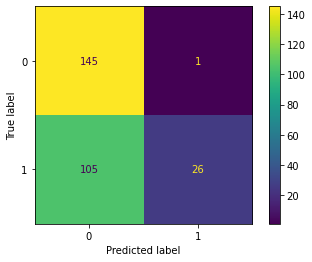

In [ ]:
import matplotlib.pyplot as plt
disp.plot()
plt.show()

In [ ]:
df = pd.read_json('gpt-3_results/yes_no_instructive')

TRUE-FALSE INSTRUCTIVE

Accuracy is 0.7111913357400722


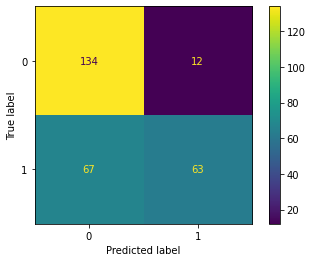

In [ ]:
# count the true and false values and use that to compute the accuracy.
accuracy = df['Match'].values.sum()/((~df['Match']).values.sum() + df['Match'].values.sum())
print("Accuracy is {}".format(accuracy))

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(df.true_label, df.pred_label, labels=[0, 1])

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# 0 entailment, 1 not entailment
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

import matplotlib.pyplot as plt
disp.plot()
plt.show()

TRUE OR FALSE IRRELEVANT

Accuracy is 0.6498194945848376


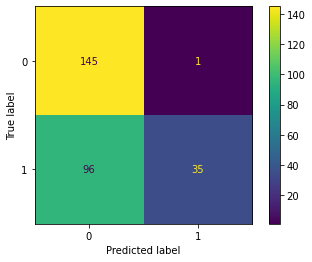

In [ ]:
# count the true and false values and use that to compute the accuracy.
accuracy = df['Match'].values.sum()/((~df['Match']).values.sum() + df['Match'].values.sum())
print("Accuracy is {}".format(accuracy))

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(df.true_label, df.pred_label, labels=[0, 1])

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# 0 entailment, 1 not entailment
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

import matplotlib.pyplot as plt
disp.plot()
plt.show()

YES NO IRRELEVANT

Accuracy is 0.6462093862815884


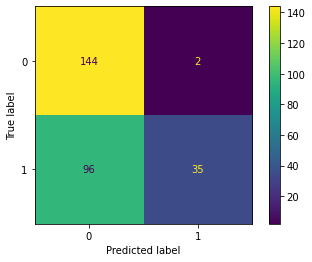

In [ ]:
# count the true and false values and use that to compute the accuracy.
accuracy = df['Match'].values.sum()/((~df['Match']).values.sum() + df['Match'].values.sum())
print("Accuracy is {}".format(accuracy))

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(df.true_label, df.pred_label, labels=[0, 1])

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# 0 entailment, 1 not entailment
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

import matplotlib.pyplot as plt
disp.plot()
plt.show()

YES NO INSTRUCTIVE

Accuracy is 0.7292418772563177


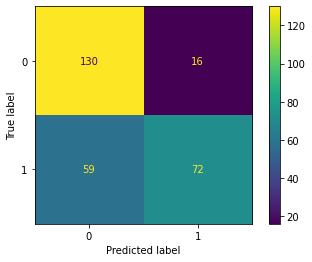

In [ ]:
# count the true and false values and use that to compute the accuracy.
accuracy = df['Match'].values.sum()/((~df['Match']).values.sum() + df['Match'].values.sum())
print("Accuracy is {}".format(accuracy))

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(df.true_label, df.pred_label, labels=[0, 1])

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# 0 entailment, 1 not entailment
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

import matplotlib.pyplot as plt
disp.plot()
plt.show()

In [ ]:
df.iloc[2]['prompt']

'Cairo is now home to some 15 million people - a burgeoning population that produces approximately 10,000 tonnes of rubbish per day, putting an enormous strain on public services. In the past 10 years, the government has tried hard to encourage private investment in the refuse sector, but some estimate 4,000 tonnes of waste is left behind every day, festering in the heat as it waits for someone to clear it up. It is often the people in the poorest neighbourhoods that are worst affected. But in some areas they are fighting back. In Shubra, one of the northern districts of the city, the residents have taken to the streets armed with dustpans and brushes to clean up public areas which have been used as public dumps. Are we justified in saying that "15 million tonnes of rubbish are produced daily in Cairo."?'